In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load data from Excel (replace with the correct file path)
df = pd.read_excel('../data.xlsx', sheet_name='Rekapan')

In [4]:
# Display the first and last few rows of the dataset
print(df.head())
print(df.tail())

     Tanggal         Nama Customer                        Lokasi Customer  \
0 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
1 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
2 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
3 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
4 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   

            Nama Produk  Type Produk       SO  TERKIRIM SISA PO INTERNAL  \
0          FIXING SCREW  Accessories  31500.0   31500.0       0        -   
1       BS-1020 BRACKET  Accessories  14900.0   13600.0    1300        -   
2  HX-SW HANDLE BRACKET  Accessories    250.0     250.0       0        -   
3          TC-303 ANGLE  Accessories  29000.0   16390.0   12610        -   
4          TC-615 ANGLE  Accessories   1650.0    1650.0       0        -   

  EKSTERNAL  Harga Komoditas Bijih Besi Indeks Produksi Dalam Negeri  \
0       

                             Tanggal            SO      TERKIRIM  \
count                          19680  1.968000e+04  1.889100e+04   
mean   2021-03-27 01:16:23.414633984  1.189907e+04  1.098127e+04   
min              2018-01-01 00:00:00  1.000000e+00  0.000000e+00   
25%              2019-07-01 00:00:00  6.000000e+02  6.000000e+02   
50%              2021-06-01 00:00:00  3.000000e+03  2.500000e+03   
75%              2022-12-01 00:00:00  9.300000e+03  8.100000e+03   
max              2024-04-01 00:00:00  3.000000e+06  1.750000e+06   
std                              NaN  5.399271e+04  4.592784e+04   

       Harga Komoditas Bijih Besi  Data Inflasi          Kurs  
count                19680.000000  19680.000000  19680.000000  
mean                   112.526491      0.030203  14672.027591  
min                     64.350000      0.013200  13413.000000  
25%                     89.550000      0.021800  14229.000000  
50%                    110.910000      0.030000  14480.000000  
75%

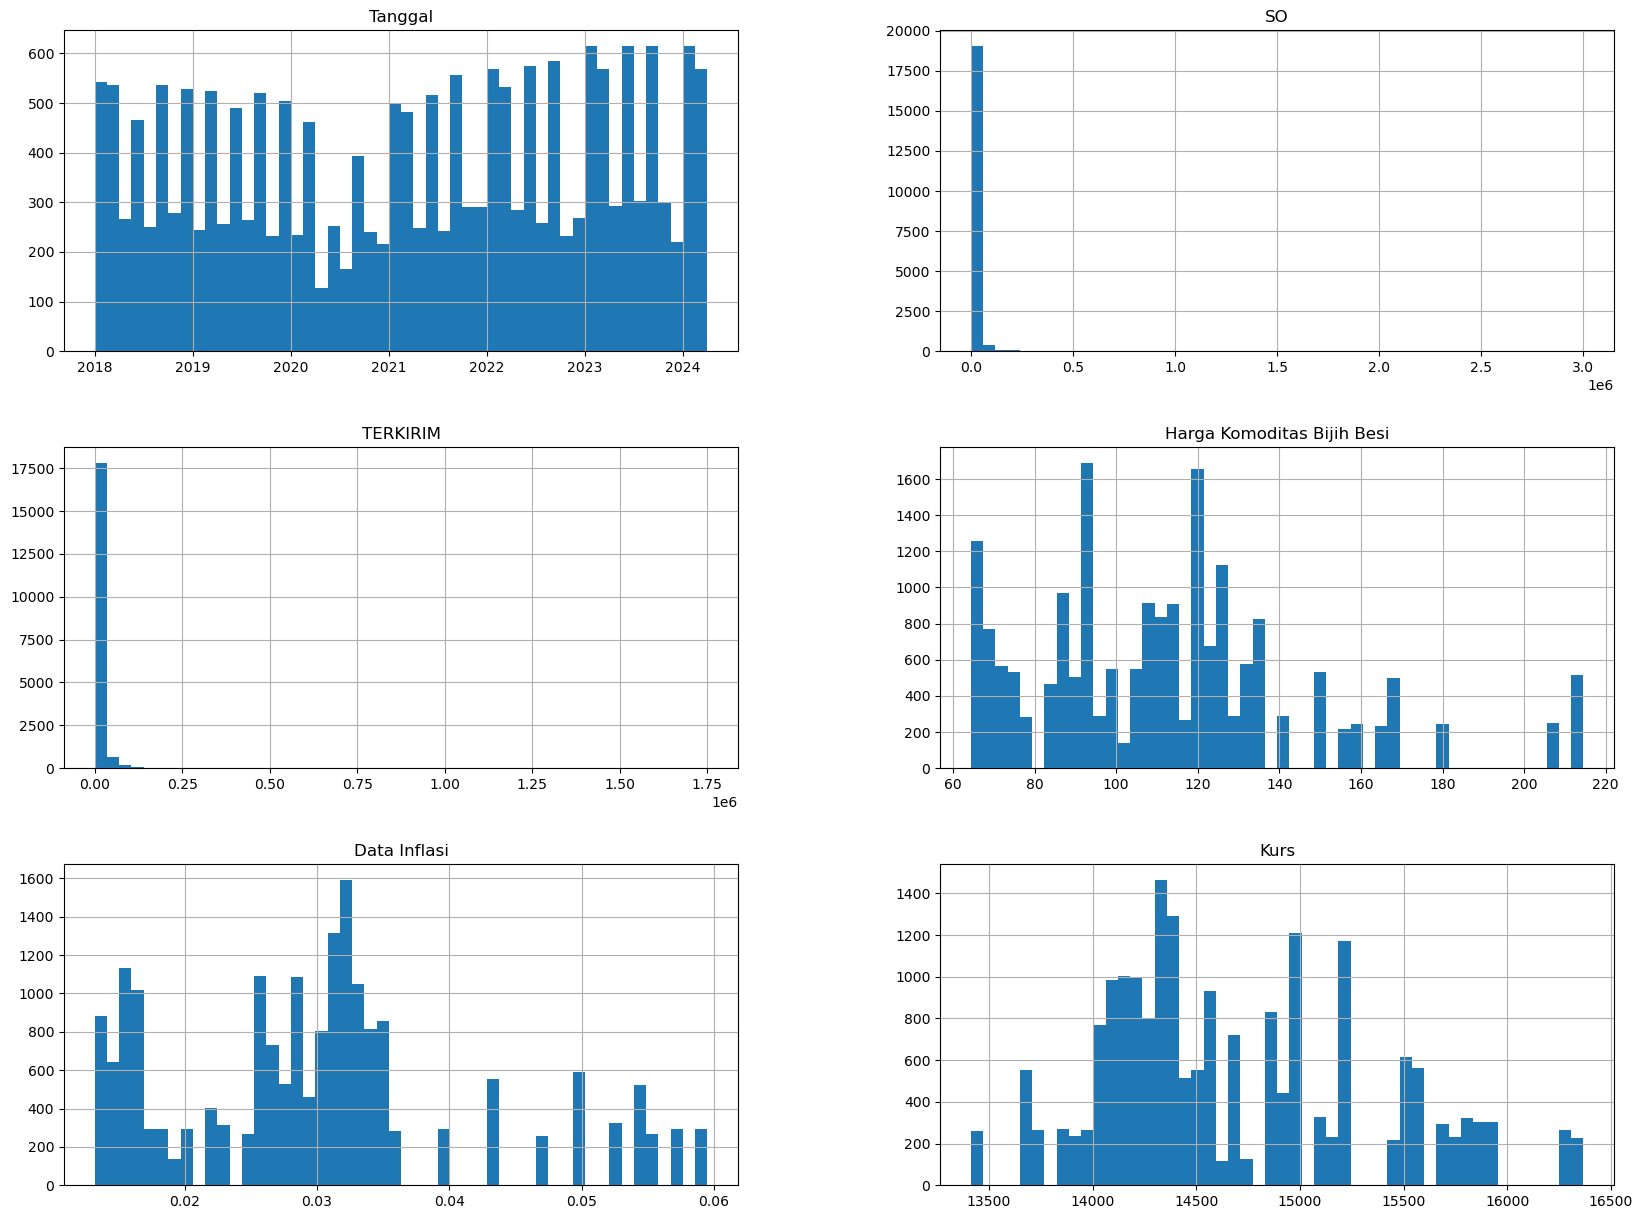

In [5]:
# Display basic descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize data distribution
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [6]:
# Filter relevant columns
data_filtered = df[['Tanggal', 'SO', 'TERKIRIM', 'Harga Komoditas Bijih Besi', 'Indeks Produksi Dalam Negeri', 'Data Inflasi', 'Kurs']]

# Rename columns for easier handling
data_filtered.columns = ['Tanggal', 'SO', 'Terkirim', 'Harga Komoditas', 'Indeks Produksi', 'Data Inflasi', 'Kurs']

# Convert 'Tanggal' column to datetime
data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])

# Convert 'Indeks Produksi' to numeric (coercing errors)
data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')

# Create 'Year' column to group by year
data_filtered['Year'] = data_filtered['Tanggal'].dt.year

# Yearly Summary by 'Year'
yearly_summary = data_filtered.groupby('Year').agg({
    'SO': 'sum',
    # Uncomment other columns as needed
    # 'Terkirim': 'sum',
    # 'Harga Komoditas': 'mean',
    # 'Indeks Produksi': 'mean',
    # 'Data Inflasi': 'mean',
    # 'Kurs': 'mean'
}).reset_index()

# Display yearly summary
print(yearly_summary)

   Year          SO
0  2018  34996710.0
1  2019  33634446.0
2  2020  44529359.0
3  2021  45957845.0
4  2022  33554300.0
5  2023  31135706.5
6  2024  10365328.0


C:\Users\chris\AppData\Local\Temp\ipykernel_15984\2235028850.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])
C:\Users\chris\AppData\Local\Temp\ipykernel_15984\2235028850.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')
C:\Users\chris\AppData\Local\Temp\ipykernel_15984\2235028850.py:14: SettingWithCopyWarning: 
A value is trying to be 

In [7]:
# Set alpha value for Double Exponential Smoothing (TES)
alpha = 0.1

# Initialize columns for TES and error metrics
yearly_summary['Single'] = np.nan
yearly_summary['Double'] = np.nan
yearly_summary['Triple'] = np.nan
yearly_summary['At'] = np.nan
yearly_summary['Bt'] = np.nan
yearly_summary['Ct'] = np.nan
yearly_summary['TES Forecast'] = np.nan
yearly_summary['Error'] = np.nan
yearly_summary['MAD'] = np.nan
yearly_summary['MSE'] = np.nan
yearly_summary['MAPE'] = np.nan


# Set initial Single, Double, At, and Bt values based on the first observation
yearly_summary.loc[0, 'Single'] = yearly_summary.loc[0, 'SO']
yearly_summary.loc[0, 'Double'] = yearly_summary.loc[0, 'SO']
yearly_summary.loc[0, 'Triple'] = yearly_summary.loc[0, 'SO']
yearly_summary.loc[0, 'At'] = (2 * yearly_summary.loc[0, 'Single']) - yearly_summary.loc[0, 'Double']
yearly_summary.loc[0, 'Bt'] = 0  # Set initial trend (Bt) to 0
yearly_summary.loc[0, 'Ct'] = 0  # Set initial trend (Ct) to 0

# Apply TES formula and calculate error metrics for each subsequent row
for i in range(1, len(yearly_summary)):
    # Single Exponential smoothing (S't)
    yearly_summary.loc[i, 'Single'] = (alpha * yearly_summary.loc[i, 'SO']) + ((1 - alpha) * yearly_summary.loc[i-1, 'Single'])
    
    # Double Exponential smoothing (S''t)
    yearly_summary.loc[i, 'Double'] = (alpha * yearly_summary.loc[i, 'Single']) + ((1 - alpha) * yearly_summary.loc[i-1, 'Double'])
    
    # Triple Exponential smoothing (S'''t)
    yearly_summary.loc[i, 'Triple'] = (alpha * yearly_summary.loc[i, 'Double']) + ((1 - alpha) * yearly_summary.loc[i-1, 'Triple'])
    
    # Triple Exponential smoothing (S'''t)
    yearly_summary.loc[i, 'Triple'] = (alpha * yearly_summary.loc[i, 'Double']) + ((1 - alpha) * yearly_summary.loc[i-1, 'Triple'])
    
    # At (level)
    yearly_summary.loc[i, 'At'] = (3 * yearly_summary.loc[i, 'Single']) - (3 * yearly_summary.loc[i, 'Double']) + yearly_summary.loc[i, 'Triple']
    
    # Bt (trend)
    yearly_summary.loc[i, 'Bt'] = ((alpha) / (2*(1 - alpha)**2)) * ((6-5*alpha)*yearly_summary.loc[i, 'Single'] - (10-8*alpha)*yearly_summary.loc[i, 'Double'] + (4-3*alpha)*yearly_summary.loc[i, 'Triple']) 
    
    # Ct (trend)
    yearly_summary.loc[i, 'Ct'] = (alpha**2)/((1 - alpha)**2) * (yearly_summary.loc[i, 'Single'] - (2*yearly_summary.loc[i, 'Double']) + yearly_summary.loc[i, 'Triple'])
    
    # TES Forecast for the next period
    if i > 0:  # Forecast from the second row onward
        yearly_summary.loc[i, 'TES Forecast'] = yearly_summary.loc[i-1, 'At'] + yearly_summary.loc[i-1, 'Bt']
    
    # Error (actual - forecast)
    yearly_summary.loc[i, 'Error'] = yearly_summary.loc[i, 'SO'] - yearly_summary.loc[i, 'TES Forecast']
    
    # MAD (Mean Absolute Deviation)
    yearly_summary.loc[i, 'MAD'] = abs(yearly_summary.loc[i, 'Error'])
    
    # MSE (Mean Squared Error)
    yearly_summary.loc[i, 'MSE'] = yearly_summary.loc[i, 'Error'] ** 2
    
    # MAPE (Mean Absolute Percentage Error)
    if yearly_summary.loc[i, 'SO'] != 0:
        yearly_summary.loc[i, 'MAPE'] = (abs(yearly_summary.loc[i, 'Error']) / yearly_summary.loc[i, 'SO']) * 100
    else:
        yearly_summary.loc[i, 'MAPE'] = np.nan

# Show the result with TES forecast and error metrics
print(yearly_summary)

   Year          SO        Single        Double        Triple            At  \
0  2018  34996710.0  3.499671e+07  3.499671e+07  3.499671e+07  3.499671e+07   
1  2019  33634446.0  3.486048e+07  3.498309e+07  3.499535e+07  3.462754e+07   
2  2020  44529359.0  3.582737e+07  3.506752e+07  3.500256e+07  3.728213e+07   
3  2021  45957845.0  3.684042e+07  3.524481e+07  3.502679e+07  3.981363e+07   
4  2022  33554300.0  3.651181e+07  3.537151e+07  3.506126e+07  3.848216e+07   
5  2023  31135706.5  3.597420e+07  3.543178e+07  3.509831e+07  3.672558e+07   
6  2024  10365328.0  3.341331e+07  3.522993e+07  3.511147e+07  2.966162e+07   

              Bt            Ct  TES Forecast         Error           MAD  \
0       0.000000      0.000000           NaN           NaN           NaN   
1  -38824.524000  -1362.264000  3.499671e+07 -1.362264e+06  1.362264e+06   
2  243141.065700   8579.064200  3.458871e+07  9.940647e+06  9.940647e+06   
3  491926.214210  17007.347860  3.752527e+07  8.432573e+06  8.4

In [8]:
# Forecast for future years (6 years ahead)
years_to_forecast = 6

# Get the last year from the original data
last_year = yearly_summary['Year'].max()

# Generate dummy years starting from the next year after the last year in the original data
dummy_years = pd.DataFrame({
    'Year': range(last_year + 1, last_year + 1 + years_to_forecast),
    'SO': np.zeros(years_to_forecast)  # Set SO to 0 for future years
})

# Combine original data with the dummy future data
extended_data = pd.concat([yearly_summary[['Year', 'SO']], dummy_years], ignore_index=True)

# Initialize columns for TES forecast in the extended data
extended_data['Single'] = np.nan
extended_data['Double'] = np.nan
extended_data['Triple'] = np.nan
extended_data['At'] = np.nan
extended_data['Bt'] = np.nan
extended_data['Ct'] = np.nan
extended_data['TES Forecast'] = np.nan
extended_data['Error'] = np.nan
extended_data['MAD'] = np.nan
extended_data['MSE'] = np.nan
extended_data['MAPE'] = np.nan

# Inisialisasi nilai awal untuk peramalan berdasarkan nilai historis pertama
extended_data.loc[0, 'Single'] = extended_data.loc[0, 'SO']
extended_data.loc[0, 'Double'] = extended_data.loc[0, 'SO']
extended_data.loc[0, 'Triple'] = extended_data.loc[0, 'SO']
extended_data.loc[0, 'At'] = (2 * extended_data.loc[0, 'Single']) - extended_data.loc[0, 'Double']
extended_data.loc[0, 'Bt'] = 0  # Assume no initial trend
extended_data.loc[0, 'Ct'] = 0  # Assume no initial trend

# Apply TES formula to historical data and future periods
for i in range(1, len(extended_data)):
    # Use the TES formula for historical and future periods
    extended_data.loc[i, 'Single'] = (alpha * extended_data.loc[i, 'SO']) + ((1 - alpha) * extended_data.loc[i-1, 'Single'])
    extended_data.loc[i, 'Double'] = (alpha * extended_data.loc[i, 'Single']) + ((1 - alpha) * extended_data.loc[i-1, 'Double'])
    extended_data.loc[i, 'Triple'] = (alpha * extended_data.loc[i, 'Double']) + ((1 - alpha) * extended_data.loc[i-1, 'Triple'])
    extended_data.loc[i, 'At'] = (3 * extended_data.loc[i, 'Single']) - (3 * extended_data.loc[i, 'Double']) + extended_data.loc[i, 'Triple']
    extended_data.loc[i, 'Bt'] = ((alpha) / (2*(1 - alpha)**2)) * ((6-5*alpha)*extended_data.loc[i, 'Single'] - (10-8*alpha)*extended_data.loc[i, 'Double'] + (4-3*alpha)*extended_data.loc[i, 'Triple']) 
    extended_data.loc[i, 'Ct'] = (alpha**2)/((1 - alpha)**2) * (extended_data.loc[i, 'Single'] - (2*extended_data.loc[i, 'Double']) + extended_data.loc[i, 'Triple'])
    extended_data.loc[i, 'TES Forecast'] = extended_data.loc[i-1, 'At'] + extended_data.loc[i-1, 'Bt']
    
    # Error
    extended_data.loc[i, 'Error'] = extended_data.loc[i, 'SO'] - extended_data.loc[i, 'TES Forecast']
    
    # MAD (Mean Absolute Deviation)
    extended_data.loc[i, 'MAD'] = abs(extended_data.loc[i, 'Error'])
    
    # MSE (Mean Squared Error)
    extended_data.loc[i, 'MSE'] = extended_data.loc[i, 'Error'] ** 2
    
    # MAPE (Mean Absolute Percentage Error)
    if extended_data.loc[i, 'SO'] != 0:
        extended_data.loc[i, 'MAPE'] = (abs(extended_data.loc[i, 'Error']) / extended_data.loc[i, 'SO']) * 100
    else:
        extended_data.loc[i, 'MAPE'] = np.nan

# Display the extended data with future forecasts
print(extended_data)


    Year          SO        Single        Double        Triple            At  \
0   2018  34996710.0  3.499671e+07  3.499671e+07  3.499671e+07  3.499671e+07   
1   2019  33634446.0  3.486048e+07  3.498309e+07  3.499535e+07  3.462754e+07   
2   2020  44529359.0  3.582737e+07  3.506752e+07  3.500256e+07  3.728213e+07   
3   2021  45957845.0  3.684042e+07  3.524481e+07  3.502679e+07  3.981363e+07   
4   2022  33554300.0  3.651181e+07  3.537151e+07  3.506126e+07  3.848216e+07   
5   2023  31135706.5  3.597420e+07  3.543178e+07  3.509831e+07  3.672558e+07   
6   2024  10365328.0  3.341331e+07  3.522993e+07  3.511147e+07  2.966162e+07   
7   2025         0.0  3.007198e+07  3.471413e+07  3.507174e+07  2.114528e+07   
8   2026         0.0  2.706478e+07  3.394920e+07  3.495949e+07  1.430623e+07   
9   2027         0.0  2.435830e+07  3.299011e+07  3.476255e+07  8.867130e+06   
10  2028         0.0  2.192247e+07  3.188335e+07  3.447463e+07  4.592010e+06   
11  2029         0.0  1.973023e+07  3.06

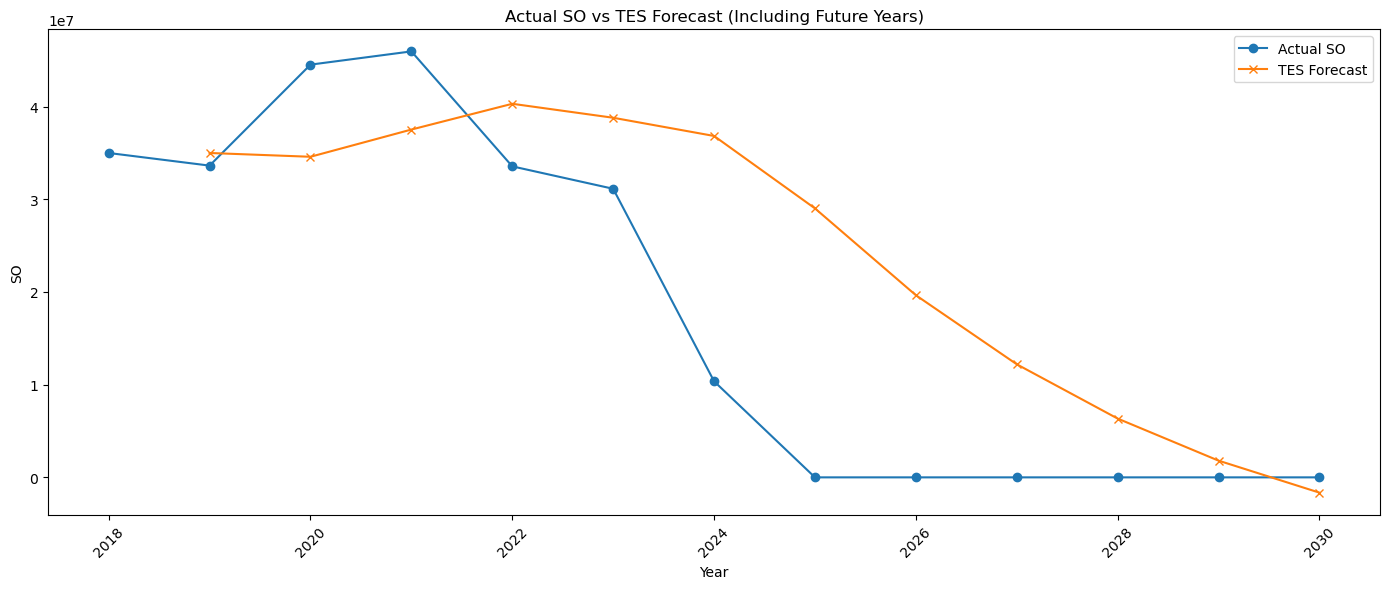

In [9]:
# Plot Actual SO vs TES Forecast, including future years
plt.figure(figsize=(14, 6))
plt.plot(extended_data['Year'], extended_data['SO'], label='Actual SO', marker='o')
plt.plot(extended_data['Year'], extended_data['TES Forecast'], label='TES Forecast', marker='x')
plt.xlabel('Year')
plt.ylabel('SO')
plt.xticks(rotation=45)
plt.title('Actual SO vs TES Forecast (Including Future Years)')
plt.legend()
plt.tight_layout()
plt.show()